# Factor Mining of Treasury Bond Futures

In [1]:
import pandas as pd
import numpy as np
from gplearn.genetic import SymbolicTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from gplearn.functions import make_function
import matplotlib.pyplot as plt
from gplearn import functions
import talib
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
matplotlib.rc("font",family='Dengxian')

##  Read data and create new data features

In [2]:
data_daily = pd.read_excel('adjusted_T_contract.xlsx')
data_minutes = pd.read_csv('daily_statistics.csv')
data_daily['date'] = pd.to_datetime(data_daily['date'])
data_minutes['date'] = pd.to_datetime(data_minutes['date'])
data = pd.merge(data_daily, data_minutes, on='date', how='left')
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])




features = ['adjusted_open', 'adjusted_high', 'adjusted_low', 'adjusted_close',  # price data 
            'position', 'turnover', 'trading_volume',  # volume data
            'daily_mean', 'daily_sd', 'daily_skewness', 'daily_kurtosis', 'daily_truncated_mean','daily_median','daily_variance','daily_interquartile_range','daily_cv','daily_adjust_vol_ratio','daily_harmonic_mean'] # 日内价格数据（已做好）

data['return'] = (data['adjusted_close'].shift(-1) - data['adjusted_close']) / data['adjusted_close']
data.loc[data.index[-1], 'return'] = 0 # lastday return is 0
target = 'return'
data = data.dropna()
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])
X = data[features]

y = data['return']

##  Formula Editing
basic formulas

In [3]:
def _log(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(x != 0, np.log(abs(x)), 0.0)

log = make_function(function=_log, name="log", arity=1)

def _exp(x):
    with np.errstate(over='ignore'):  
        return np.where(np.abs(x) < 100, np.exp(x), np.exp(100))  

exp = make_function(function=_exp, name="exp", arity=1)

def _power(x, y):
    with np.errstate(over='ignore', invalid='ignore'):
        return np.where(x >= 0, np.power(x, y), 0.0)

power = make_function(function=_power, name="power", arity=2)

def _moving_avg(x):
    # moving avg window = 3
    return np.convolve(x, np.ones(3)/3, mode='same')

moving_avg = make_function(function=_moving_avg, name="mov_avg", arity=1)

def _clip(x, a, b):
    # clip values to the range [a, b]
    return np.clip(x, a, b)

clip = make_function(function=_clip, name="clip", arity=3)

def diff(x):
    return np.append([0], np.diff(x))

diff_func = make_function(function=diff, name="diff", arity=1)

formulas

In [4]:
def rolling_std(x):
    # rolling std window = 5
    if len(x) < 5:
        return np.zeros_like(x)  
    result = np.zeros_like(x)
    for i in range(len(x)):
        if i < 4: 
            result[i] = 0
        else:
            result[i] = np.std(x[i-4:i+1]) 
    return result

def ts_sum(x):
    # sum of last 5 values
    if len(x) < 5:
        return np.zeros_like(x)  
    result = np.zeros_like(x)
    for i in range(len(x)):
        if i < 4:  
            result[i] = 0
        else:
            result[i] = np.sum(x[i-4:i+1])  
    return result


def ts_prod(x):
    # product of last 5 values
    if len(x) < 5:
        return np.ones_like(x) 
    result = np.ones_like(x)
    for i in range(len(x)):
        if i < 4:  
            result[i] = 1
        else:
            result[i] = np.prod(x[i-4:i+1]) 
    return result

rolling_std_func = make_function(function=rolling_std, name='rolling_std', arity=1)
ts_sum_func = make_function(function=ts_sum, name='ts_sum', arity=1)
ts_prod_func = make_function(function=ts_prod, name='ts_prod', arity=1)

talib Formulas

In [5]:
def talib_sma(x):
    """TA-Lib SMA function wrapper for gplearn"""
    # talib.SMA 
    period = 5
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.SMA(x, timeperiod=period)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result

def talib_ma(x):
    period = 5
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.MA(x, timeperiod=period, matype=0)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result

def talib_wma(x):
    period = 5
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.WMA(x, timeperiod=period)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result

def talib_ema(x):
    period = 5
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.EMA(x, timeperiod=period)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result

def talib_dema(x):
    period = 5
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.DEMA(x, timeperiod=period)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result

def talib_kama(x):
    period = 5
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.KAMA(x, timeperiod=period)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result

def talib_tema(x):
    period = 5
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.TEMA(x, timeperiod=period)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_mavp(x,y):
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    if y.ndim > 1:
        y = y.flatten()
    period = max(1, int(period))
    result = talib.MAVP(x,y,minperiod=2,maxperiod=30, matype=0)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result

def talib_rsi(x):
    period = 5
    if x.ndim > 1:
        x = x.flatten()
    result = talib.RSI(x, timeperiod=period)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result

def talib_bbands(x):
    if x.ndim > 1:
        x = x.flatten()
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    upperband, middleband, lowerband = talib.BBANDS(x, timeperiod=14, nbdevup=2, nbdevdn=2, matype=0)
    if np.isnan(middleband).any():
        middleband = np.nan_to_num(middleband)
    return middleband

def talib_midpoint(x):
    period = 5
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.MIDPOINT(x, timeperiod=14)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_t3(x):
    period = 5
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.T3(x, timeperiod=period, vfactor=0)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result

def talib_macd(x):
    period = 5
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    macd, signal, hist = talib.MACD(x, fastperiod=12, slowperiod=26, signalperiod=9)
    if np.isnan(macd).any():
        macd = np.nan_to_num(macd)
    return macd


def talib_apo(x): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.APO(x, fastperiod=12, slowperiod=26, matype=0)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result

def talib_cmom(x): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.CMO(x, timeperiod=14)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_mom(x):
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.MOM(x, timeperiod=14)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_roc(x): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.ROC(x, timeperiod=14)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talic_rocp(x): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.ROCP(x, timeperiod=14)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_rocr(x):
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.ROCR(x, timeperiod=14)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_trix(x): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.TRIX(x, timeperiod=14)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_linearreg(x):
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.LINEARREG(x, timeperiod=14)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_linearreg_angle(x): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.LINEARREG_ANGLE(x, timeperiod=14)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_linearreg_intercept(x):
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.LINEARREG_INTERCEPT(x, timeperiod=14)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_stddev(x): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.STDDEV(x, timeperiod=14)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_tsf(x): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.TSF(x, timeperiod=14)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_var(x): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.VAR(x, timeperiod=14)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_sar(x,y): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    if y.ndim > 1:
        y = y.flatten()
    period = max(1, int(period))
    result = talib.SAR(x,y, acceleration=0, maximum=0)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_ht_trendline(x): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.HT_TRENDLINE(x)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_ht_dcperiod(x): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.HT_DCPERIOD(x)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_ht_dcphase(x):
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.HT_DCPHASE(x)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_ht_dcphasor(x): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result,quadrature = talib.HT_PHASOR(x)
    if np.isnan(result).any():
        result = np.nan_to_num(result)
    return result
def talib_ht_sine(x): 
    period = 14
    if x.ndim > 1:
        x = x.flatten()
    period = max(1, int(period))
    result = talib.HT_SINE(x)
    if np.isnan(result).any():
        result,leadsine = np.nan_to_num(result)
    return result


sma_func = make_function(function=talib_sma, name='sma', arity=1)
ema_func = make_function(function=talib_ema, name='ema', arity=1)
dema_func = make_function(function=talib_dema, name='dema', arity=1)
ma_func = make_function(function=talib_ma, name='ma', arity=1)
kama_func = make_function(function=talib_kama, name='kama', arity=1)
wma_func = make_function(function=talib_wma, name='wma', arity=1)
mavp_func = make_function(function=talib_mavp, name='mavp',arity=2)
rsi_func = make_function(function=talib_rsi, name='rsi', arity=1)
bbands_func = make_function(function=talib_bbands, name='bbands', arity=1)
midpoint_func = make_function(function=talib_midpoint, name='midpoint', arity=1)
t3_func = make_function(function=talib_t3, name='t3', arity=1)
tema_func = make_function(function=talib_tema, name='tema', arity=1)
macd_func = make_function(function=talib_macd, name='macd', arity=1)
apo_func = make_function(function=talib_apo, name='apo', arity=1)
cmom_func = make_function(function=talib_cmom, name='cmom', arity=1)
mom_func = make_function(function=talib_mom, name='mom', arity=1)
roc_func = make_function(function=talib_roc, name='roc', arity=1)
rocp_func = make_function(function=talic_rocp, name='rocp', arity=1)
rocr_func = make_function(function=talib_rocr, name='rocr', arity=1)
trix_func = make_function(function=talib_trix, name='trix', arity=1)
linearreg_func = make_function(function=talib_linearreg, name='linearreg', arity=1)
linearreg_angle_func = make_function(function=talib_linearreg_angle, name='linearreg_angle', arity=1)
linearreg_intercept_func = make_function(function=talib_linearreg_intercept, name='linearreg_intercept', arity=1)
stddev_func = make_function(function=talib_stddev, name='stddev', arity=1)
tsf_func = make_function(function=talib_tsf, name='tsf', arity=1)
var_func = make_function(function=talib_var, name='var', arity=1)
sar_func = make_function(function=talib_sar, name='sar', arity=2)
ht_trendline_func = make_function(function=talib_ht_trendline, name='ht_trendline', arity=1)
ht_dcperiod_func = make_function(function=talib_ht_dcperiod, name='ht_dcperiod', arity=1)
ht_dcphase_func = make_function(function=talib_ht_dcphase, name='ht_dcphase', arity=1)
ht_dcphasor_func = make_function(function=talib_ht_dcphasor, name='ht_dcphasor', arity=1)
ht_sine_func = make_function(function=talib_ht_sine, name='ht_sine', arity=1)

##  Factor Mining Using Genetic Algorithm

In [6]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'abs', 'neg', 'inv', 'max', 'min', 'sin','cos','tan',
                # exp, log, #moving_avg,
                diff_func, rolling_std_func, ts_sum_func, #ts_prod_func,
                sma_func, ma_func,ema_func,dema_func,kama_func,wma_func, #mavp_func,
                rsi_func, bbands_func,midpoint_func, t3_func,tema_func,macd_func,
                apo_func,cmom_func,mom_func,roc_func,rocp_func,rocr_func,trix_func,linearreg_func,
                stddev_func,tsf_func,var_func,linearreg_angle_func,linearreg_intercept_func,sar_func,
                ht_trendline_func,ht_dcperiod_func,ht_dcphase_func,ht_dcphasor_func,ht_sine_func]
                

In [7]:
# time periods for rolling window of training and testing
train_start, train_end = "2018-01-01", "2022-12-31"
test_start, test_end = "2023-01-01", "2024-12-31"

# train and test data
train_data = data[(data["date"] >= train_start) & (data["date"] <= train_end)]
test_data = data[(data["date"] >= test_start) & (data["date"] <= test_end)]
rolling_periods = [
    ("2018-01-01", "2020-12-31"),
    ("2019-01-01", "2021-12-31"),
    ("2020-01-01", "2022-12-31")
]

In [8]:
data.shape, train_data.shape, test_data.shape

((1692, 43), (1215, 43), (477, 43))

In [9]:
all_transformed_factors = []
st = SymbolicTransformer(
    generations=5,
    population_size=1000,   # 1000 population
    hall_of_fame=100,   # elite 100
    n_components=10, # 10 factors
    function_set=function_set, # function set
    parsimony_coefficient=0.0006, 
    max_samples=0.9, 
    verbose=1, # log
    metric="spearman", # spearman correlation
    random_state=42, 
    p_crossover=0.8,  # crossover probability
    p_subtree_mutation=0.005,   
    p_hoist_mutation = 0.005,  
    p_point_mutation=0.005  
)

all_factors = pd.DataFrame()
all_factors_full = pd.DataFrame()
all_factors_test = pd.DataFrame()
formula_name = {}
for i, (start, end) in  enumerate(rolling_periods):
    rolling_data = train_data[(train_data["date"] >= start) & (train_data["date"] <= end)]
    X = rolling_data[features]
    y = rolling_data[target]
    st.fit(X, y) # model
    X_train_full = train_data[features]
    X_all_full = data[features]
    all_transformed_features = st.transform(X_all_full)
    transformed_features = st.transform(X_train_full)
    # factors
    transformed_factors = pd.DataFrame(transformed_features, columns=[f"factor_{i+1}_{j}" for j in range(transformed_features.shape[1])],index=X_train_full.index)
    all_transformed_factors = pd.DataFrame(all_transformed_features, columns=[f"factor_{i+1}_{j}" for j in range(all_transformed_features.shape[1])],index=X_all_full.index)

    all_factors = pd.concat([all_factors, transformed_factors], axis=1) # concat factors
    all_factors_full = pd.concat([all_factors_full, all_transformed_factors], axis=1) 
    for j in range(10):
        factor_now = f"factor_{i+1}_{j}"
        formula_name[f"factor_{i+1}_{j}"] = st._best_programs[j]
    

train_data_with_factors = pd.concat([train_data, all_factors], axis=1)
data_with_factors = pd.concat([data, all_factors_full], axis=1)


scores = {}
for factor in all_factors.columns:
    X_train_now = train_data_with_factors[factor].dropna()
    y_train_now = train_data_with_factors.loc[X_train_now.index, target]
    score, _ = spearmanr(X_train_now, y_train_now)
    scores[factor] = score  

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     5.75        0.0348811        8         0.141069       0.00107051     17.75s
   1     4.73        0.0686755        3         0.168234         0.106819      7.34s
   2     4.57        0.0895917        5         0.178331         0.160384      3.57s
   3     4.22          0.10114        3         0.178483         0.205428      1.53s
   4     3.87         0.114689        9         0.194525        0.0910203      0.00s
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     5.75        0.0290423        3         0.120257        0.0214375     16.53s


In [10]:
# select top 10 factors based on Spearman correlation
selected_factors = sorted(scores, key=scores.get, reverse=True)[:10]
for item in selected_factors:
    print(f"{item}: {formula_name[item]}")

factor_2_1: dema(ma(diff(mom(ht_dcphasor(neg(X7))))))
factor_3_2: div(ht_dcperiod(roc(ht_sine(X8))), tema(ht_dcphase(rsi(mul(X10, X10)))))
factor_3_3: ht_dcphase(linearreg(sar(cmom(ht_dcphase(linearreg(sar(cmom(linearreg_angle(apo(linearreg_angle(X3)))), X11)))), X11)))
factor_3_5: add(X2, bbands(sqrt(rocr(ema(rolling_std(ht_dcphase(ht_dcphase(ht_dcphase(linearreg(sar(cmom(tsf(linearreg_angle(apo(linearreg_angle(X3))))), X11)))))))))))
factor_3_8: ht_dcphase(rsi(add(X2, bbands(sqrt(rocr(ema(rolling_std(ht_dcphase(ht_dcphase(X9))))))))))
factor_2_8: max(sub(min(X2, X10), add(X13, X4)), sub(mom(X9), sqrt(X8)))
factor_3_4: max(stddev(ht_sine(X8)), add(X2, bbands(sqrt(diff(ht_sine(X13))))))
factor_3_6: max(stddev(ht_sine(X8)), add(X2, bbands(sqrt(ht_dcphase(sub(X17, X4))))))
factor_3_9: sma(rocr(ema(rolling_std(ema(rolling_std(ht_dcphase(ht_dcphase(X9))))))))
factor_3_1: max(ht_dcphase(mul(X10, X10)), ht_dcphasor(X17))


In [11]:
# compute correlation for test data
data_with_factors['date'] = pd.to_datetime(data_with_factors['date'])
test_data_with_factors = data_with_factors[(data_with_factors["date"] >= test_start) & (data_with_factors["date"] <= test_end)]

for item in selected_factors:
    test_pearsonr = pearsonr(test_data_with_factors[item], test_data_with_factors[target])
    test_spearmanr = spearmanr(test_data_with_factors[item], test_data_with_factors[target])
    print(f"{item}: {test_pearsonr}, {test_spearmanr}")

factor_2_1: PearsonRResult(statistic=-0.025506073901963508, pvalue=0.5784228583117077), SignificanceResult(statistic=-0.07784732053914638, pvalue=0.08944580649026615)
factor_3_2: PearsonRResult(statistic=0.005637692936310047, pvalue=0.9022599364080022), SignificanceResult(statistic=0.021617415866715044, pvalue=0.637678019491122)
factor_3_3: PearsonRResult(statistic=-0.07761024780566449, pvalue=0.09042869697261696), SignificanceResult(statistic=-0.031240482325217058, pvalue=0.49607499081137796)
factor_3_5: PearsonRResult(statistic=0.055653297823795814, pvalue=0.22503893925032828), SignificanceResult(statistic=0.025792561460834244, pvalue=0.5741612916535035)
factor_3_8: PearsonRResult(statistic=-0.05389483480419129, pvalue=0.24005607528489606), SignificanceResult(statistic=-0.020198722158440804, pvalue=0.6599123340621502)
factor_2_8: PearsonRResult(statistic=-0.0747745619735299, pvalue=0.10286913716649852), SignificanceResult(statistic=-0.04882657025019051, pvalue=0.2872266319548791)
fac

c:\python312\Lib\site-packages\scipy\stats\_stats_py.py:4847: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


##  Backtesting

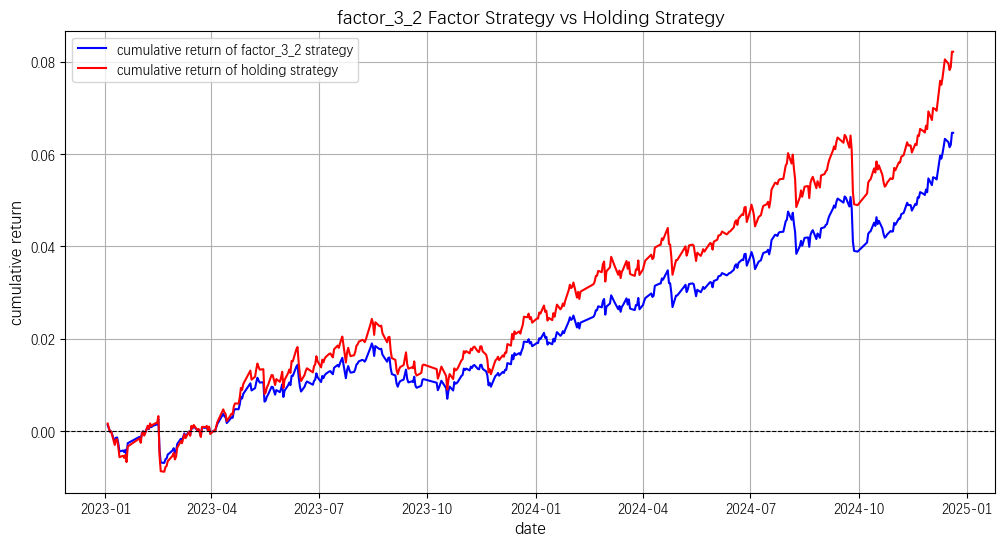

In [12]:
i = 3
j = 2  # factor index
test_data_with_factors = test_data_with_factors.sort_values(by='date').reset_index(drop=True)
factor_name = f'factor_{i}_{j}'  # factor name
# normalize the factor values
test_data_with_factors[f'factor_{i}_{j}_std'] = (test_data_with_factors[factor_name] - train_data_with_factors[factor_name].min()) / (train_data_with_factors[factor_name].max()-train_data_with_factors[factor_name].min())
# compute the position based on the factor values
test_data_with_factors['position_now'] = test_data_with_factors[f'factor_{i}_{j}_std']
# compute the position based on the factor values
test_data_with_factors['daily_return'] = test_data_with_factors['return'] * test_data_with_factors['position_now']
# compute the cumulative return of the strategy
test_data_with_factors['cum_return'] = test_data_with_factors['daily_return'].cumsum()
# compute the cumulative return of the buy-and-hold strategy
test_data_with_factors['buy_and_hold_return'] = test_data_with_factors['return'].cumsum()

# visualize the results
plt.figure(figsize=(12, 6))
plt.plot(test_data_with_factors['date'], test_data_with_factors['cum_return'], label=f'cumulative return of factor_{i}_{j} strategy', color='blue')
plt.plot(test_data_with_factors['date'], test_data_with_factors['buy_and_hold_return'], label='cumulative return of holding strategy', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('date', fontsize=12)
plt.ylabel('cumulative return', fontsize=12)
plt.title(f'factor_{i}_{j} Factor Strategy vs Holding Strategy', fontsize=14)
plt.legend()
plt.grid()
plt.show()